In [ ]:
# Predicting CPU and Memory Usage for Cluster-level Monitoring

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)

# Configure GPU memory growth (if available)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Matplotlib is building the font cache; this may take a moment.


TensorFlow version: 2.15.0
GPU available: False


In [2]:
# make sure we’re running in the notebook’s folder
NOTEBOOK_DIR = os.getcwd()
MODEL_DIR    = os.path.join(NOTEBOOK_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

class DataProcessor:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.scaler_features = StandardScaler()
        self.scaler_targets = MinMaxScaler()
        
    def load_and_preprocess(self):
        """Load CSV and perform initial preprocessing"""
        print("Loading data from CSV...")
        df = pd.read_csv(self.csv_path)
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Derive cluster-level CPU and memory percentages
        print("Deriving cluster-level CPU and memory percentages...")
        # # Direct calculation from allocation efficiency and node usage
        # df['cluster_cpu_percentage'] = df['cpu_allocation_efficiency'] * df['node_cpu_usage']
        # df['cluster_memory_percentage'] = df['memory_allocation_efficiency'] * df['node_memory_usage']
        
        # Alternative method: Weighted average approach
        # df['cluster_cpu_percentage'] = (df['cpu_allocation_efficiency'] * 0.7 + df['node_cpu_usage'] * 0.3)
        # df['cluster_memory_percentage'] = (df['memory_allocation_efficiency'] * 0.7 + df['node_memory_usage'] * 0.3)
        
        # # Clip values to reasonable ranges (0-100% for percentages)
        # df['cluster_cpu_percentage'] = np.clip(df['cluster_cpu_percentage'], 0, 100)
        # df['cluster_memory_percentage'] = np.clip(df['cluster_memory_percentage'], 0, 100)
        
        # print(f"Data shape: {df.shape}")
        # print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        # print(f"CPU range: {df['cluster_cpu_percentage'].min():.2f}% - {df['cluster_cpu_percentage'].max():.2f}%")
        # print(f"Memory range: {df['cluster_memory_percentage'].min():.2f}% - {df['cluster_memory_percentage'].max():.2f}%")
        
        return df
    
    def resample_to_5min(self, df):
        """Resample 1-minute data to 5-minute intervals"""
        print("Resampling data from 1-minute to 5-minute intervals...")
        
        df = df.set_index('timestamp')
        
        # Resample numeric columns - using mean for most metrics
        numeric_cols = ['disk_io', 'node_temperature', 
                      'node_cpu_usage', 'node_memory_usage', 'pod_lifetime_seconds',
                      ] # 'cpu_allocation_efficiency', 'memory_allocation_efficiency', 'network_latency','cluster_cpu_percentage', 'cluster_memory_percentage'
        resampled = df[numeric_cols].resample('1T').mean()
        
        # For event_type, use the most frequent value in each 5-minute window
        resampled['event_type'] = df['event_type'].resample('1T').apply(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
        
        result = resampled.reset_index()
        result = result.dropna()  # Remove any NaN values from resampling
        
        print(f"Resampled data shape: {result.shape}")
        print(f"Data points reduced from {len(df)} to {len(result)} (factor of {len(df)//len(result):.1f})")
        
        return result
    
    def prepare_sequences(self, df, sequence_length=24, prediction_horizon=12):
        """
        Prepare sequences for LSTM training
        sequence_length: Number of past time steps to use (24 = 2 hours of 5-min data)
        prediction_horizon: Number of future steps to predict (12 = 1 hour)
        """
        print(f"Preparing sequences (seq_len={sequence_length}, pred_horizon={prediction_horizon})...")
        
        # Sort by timestamp
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        # Feature columns (excluding targets and identifiers)
        feature_cols = ['disk_io', 'node_temperature', 'pod_lifetime_seconds'] # 'cpu_allocation_efficiency', 'memory_allocation_efficiency', 'network_latency', 'node_cpu_usage', 'node_memory_usage',
        
        # Target columns
        target_cols = ['node_cpu_usage', 'node_memory_usage'] # ['cluster_cpu_percentage', 'cluster_memory_percentage']
        
        # Check if we have enough data
        if len(df) < sequence_length + prediction_horizon:
            raise ValueError(f"Insufficient data: need at least {sequence_length + prediction_horizon} rows, got {len(df)}")
        
        # Prepare features and targets
        features = df[feature_cols].values
        targets = df[target_cols].values
        
        sequences_X, sequences_y, timestamps = [], [], []
        
        # Create sequences
        for i in range(len(df) - sequence_length - prediction_horizon + 1):
            X_seq = features[i:i + sequence_length]
            y_seq = targets[i + sequence_length:i + sequence_length + prediction_horizon]
            
            sequences_X.append(X_seq)
            sequences_y.append(y_seq)
            timestamps.append(df.iloc[i + sequence_length]['timestamp'])
        
        sequences_X = np.array(sequences_X)
        sequences_y = np.array(sequences_y)
        
        print(f"Created {len(sequences_X)} sequences")
        print(f"Input shape: {sequences_X.shape}")
        print(f"Output shape: {sequences_y.shape}")
        
        return sequences_X, sequences_y, np.array(timestamps)
    
    def normalize_data(self, X_train, y_train, X_val=None, y_val=None):
        """Normalize features and targets"""
        print("Normalizing data...")
        
        # Reshape for scaling
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])
        
        # Fit scalers on training data
        X_train_scaled = self.scaler_features.fit_transform(X_train_reshaped)
        y_train_scaled = self.scaler_targets.fit_transform(y_train_reshaped)
        
        # Reshape back
        X_train_scaled = X_train_scaled.reshape(X_train.shape)
        y_train_scaled = y_train_scaled.reshape(y_train.shape)
        
        if X_val is not None and y_val is not None:
            X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
            y_val_reshaped = y_val.reshape(-1, y_val.shape[-1])
            
            X_val_scaled = self.scaler_features.transform(X_val_reshaped)
            y_val_scaled = self.scaler_targets.transform(y_val_reshaped)
            
            X_val_scaled = X_val_scaled.reshape(X_val.shape)
            y_val_scaled = y_val_scaled.reshape(y_val.shape)
            
            return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled
        
        return X_train_scaled, y_train_scaled
    
    def save_scalers(self, path="scalers/"):
        """Save the fitted scalers"""
        os.makedirs(path, exist_ok=True)
        with open(f"{path}/feature_scaler.pkl", 'wb') as f:
            pickle.dump(self.scaler_features, f)
        with open(f"{path}/target_scaler.pkl", 'wb') as f:
            pickle.dump(self.scaler_targets, f)
        print(f"Scalers saved to {path}")
    
    def load_scalers(self, path="scalers/"):
        """Load the fitted scalers"""
        with open(f"{path}/feature_scaler.pkl", 'rb') as f:
            self.scaler_features = pickle.load(f)
        with open(f"{path}/target_scaler.pkl", 'rb') as f:
            self.scaler_targets = pickle.load(f)
        print(f"Scalers loaded from {path}")


In [4]:

# =============================================================================
# 2. LSTM MODEL ARCHITECTURE
# =============================================================================

class MultiOutputLSTM:
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 prediction_horizon, dropout=0.2, use_attention=True):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.prediction_horizon = prediction_horizon
        self.dropout = dropout
        self.use_attention = use_attention
        self.model = None
        
    def build_model(self):
        """Build the TensorFlow/Keras model"""
        print("Building TensorFlow LSTM model...")
        
        # Input layer
        inputs = layers.Input(shape=(None, self.input_size), name='input_sequences')
        
        # LSTM layers
        x = inputs
        for i in range(self.num_layers):
            return_sequences = (i < self.num_layers - 1) or self.use_attention
            x = layers.LSTM(
                self.hidden_size,
                return_sequences=return_sequences,
                dropout=self.dropout if i < self.num_layers - 1 else 0,
                recurrent_dropout=self.dropout if i < self.num_layers - 1 else 0,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                name=f'lstm_{i+1}'
            )(x)
        
        # Attention mechanism (optional)
        if self.use_attention:
            attention_layer = layers.MultiHeadAttention(
                num_heads=4, 
                key_dim=self.hidden_size // 4,
                name='multi_head_attention'
            )
            x = attention_layer(x, x)
            # Take the last time step after attention
            x = layers.Lambda(lambda x: x[:, -1, :], name='last_timestep')(x)
        
        # Dropout
        x = layers.Dropout(self.dropout, name='dropout_final')(x)
        
        # Dense layers
        x = layers.Dense(
            self.hidden_size // 2, 
            activation='relu', 
            kernel_initializer='glorot_uniform',
            name='dense_1'
        )(x)
        x = layers.Dropout(self.dropout, name='dropout_dense')(x)
        
        # Output layer
        output = layers.Dense(
            self.output_size * self.prediction_horizon,
            kernel_initializer='glorot_uniform',
            name='output_dense'
        )(x)
        
        # Reshape to (batch_size, prediction_horizon, output_size)
        output = layers.Reshape(
            (self.prediction_horizon, self.output_size), 
            name='output_reshape'
        )(output)
        
        # Create model
        self.model = keras.Model(inputs=inputs, outputs=output, name='MultiOutputLSTM')
        
        return self.model
    
    def get_model_summary(self):
        """Print model summary"""
        if self.model is None:
            self.build_model()
        return self.model.summary()



In [ ]:
# =============================================================================
# 3. CUSTOM LOSS FUNCTION
# =============================================================================

def disaster_aware_loss(threshold=0.7, disaster_penalty_weight=2.0):
    """Custom loss function that penalizes disaster threshold breaches more"""
    def loss_fn(y_true, y_pred):
        # Standard MSE loss
        loss = tf.keras.losses.MeanSquaredError(
                reduction='sum_over_batch_size',
                name='mean_squared_error'
            )
        mse_loss = loss.call(y_true, y_pred)

        
        # Additional penalty for predictions that miss disaster conditions
        disaster_mask = tf.cast(y_true > threshold, tf.float32)
        disaster_errors = tf.abs(y_pred - y_true) * disaster_mask
        disaster_penalty = tf.reduce_mean(disaster_errors) * disaster_penalty_weight
        
        return mse_loss + disaster_penalty
    
    return loss_fn


In [ ]:
# =============================================================================
# 4. TRAINING PIPELINE
# =============================================================================

class LSTMTrainer:
    def __init__(self, model, model_save_path="models/"):
        self.model = model
        self.model_save_path = model_save_path
        self.history = None
        os.makedirs(model_save_path, exist_ok=True)
        
    def compile_model(self, learning_rate=0.001):
        """Compile the model with optimizer and loss function"""
        optimizer = optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=1e-4
        )
        
        # Use custom disaster-aware loss
        loss_fn = disaster_aware_loss(threshold=0.7, disaster_penalty_weight=2.0)
        
        self.model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['mse', 'mae']
        )
        
        print("Model compiled successfully!")
    
    def create_callbacks(self):
        """Create training callbacks"""
        callbacks_list = [
            # Early stopping
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            ),
            
            # Reduce learning rate on plateau
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7,
                verbose=1
            ),
            
            # Model checkpoint - save best model
            callbacks.ModelCheckpoint(
                filepath=os.path.join(self.model_save_path, 'best_model.h5'),
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            ),
            
            # CSV logger
            callbacks.CSVLogger(
                os.path.join(self.model_save_path, 'training_log.csv')
            ),
            
            # Gradient clipping through callback
            callbacks.LambdaCallback(
                on_batch_end=lambda batch, logs: None  # Gradient clipping is handled in optimizer
            )
        ]
        
        return callbacks_list
    
    def train_model(self, X_train, y_train, X_val, y_val, epochs=150, batch_size=64):
        """Train the LSTM model"""
        print("Training model...")
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Validation samples: {X_val.shape[0]}")
        
        # Create callbacks
        callbacks_list = self.create_callbacks()
        
        # Train the model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=1,
            shuffle=True
        )
        
        print("Training completed!")
        return self.history
    
    def plot_training_history(self):
        """Plot training and validation metrics"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        axes[0, 0].plot(self.history.history['loss'], label='Training Loss', alpha=0.8)
        axes[0, 0].plot(self.history.history['val_loss'], label='Validation Loss', alpha=0.8)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # MSE
        axes[0, 1].plot(self.history.history['mse'], label='Training MSE', alpha=0.8)
        axes[0, 1].plot(self.history.history['val_mse'], label='Validation MSE', alpha=0.8)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('MSE')
        axes[0, 1].set_title('Mean Squared Error')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # MAE
        axes[1, 0].plot(self.history.history['mae'], label='Training MAE', alpha=0.8)
        axes[1, 0].plot(self.history.history['val_mae'], label='Validation MAE', alpha=0.8)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('MAE')
        axes[1, 0].set_title('Mean Absolute Error')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Recent validation loss
        recent_epochs = min(50, len(self.history.history['val_loss']))
        axes[1, 1].plot(
            self.history.history['val_loss'][-recent_epochs:], 
            label=f'Validation Loss (Last {recent_epochs} epochs)', 
            color='orange'
        )
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].set_title('Recent Validation Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()



In [7]:
# =============================================================================
# 5. MODEL SAVING AND LOADING
# =============================================================================

class ModelManager:
    def __init__(self, model_path="models/"):
        self.model_path = model_path
        os.makedirs(model_path, exist_ok=True)
    
    def save_model(self, model, model_name="kubernetes_lstm_model"):
        """
        Save model in multiple formats:
        2. HDF5 format (for easy loading)
        """
        print(f"Saving model to {self.model_path}...")
             
        # 2. HDF5 format (lightweight, easy to load)
        h5_path = os.path.join(self.model_path, f"{model_name}.h5")
        model.save(h5_path, save_format='h5')
        print(f"✓ HDF5 model saved to: {h5_path}")
        
        # 4. Save model architecture as JSON
        architecture_path = os.path.join(self.model_path, f"{model_name}_architecture.json")
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
        print(f"✓ Model architecture saved to: {architecture_path}")
        
        print("Model saving completed!")
    
    def load_model(self, model_name="kubernetes_lstm_model", load_format="h5"):
        """
        Load model from different formats
        
        Args:
            model_name: Name of the model files
            load_format: h5'
        """
        print(f"Loading model from {self.model_path}...")
        
        try:    
            model_path = os.path.join(self.model_path, f"{model_name}.h5")
            model = keras.models.load_model(
                model_path,
                custom_objects={'loss_fn': disaster_aware_loss()}
            )
            print(f"✓ HDF5 model loaded from: {model_path}")
                
        except Exception:
            raise ValueError("Unable to load model")
        return model
    
    def list_saved_models(self):
        """List all saved models in the model directory"""
        print(f"Models in {self.model_path}:")
        for item in os.listdir(self.model_path):
            print(f"  - {item}")



In [ ]:
csv_path = "./data/kubernetes_performance_metrics_dataset.csv"

# 1. Data Processing
print("=" * 60)
print("KUBERNETES LSTM DISASTER RECOVERY SYSTEM - TENSORFLOW")
print("=" * 60)

processor = DataProcessor(csv_path)

# Load and preprocess data
df = processor.load_and_preprocess()

# Resample to 5-minute intervals
df_resampled = processor.resample_to_5min(df)

# Prepare sequences
X, y, timestamps = processor.prepare_sequences(df_resampled)

# Train/validation/test split (70/20/10)
train_idx = int(0.7 * len(X))
val_idx = int(0.9 * len(X))

X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]

# Normalize data
X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled = processor.normalize_data(
    X_train, y_train, X_val, y_val
)

# Save scalers for later use
processor.save_scalers()

print("\nDataset splits:")
print(f"Training samples: {len(X_train_scaled)}")
print(f"Validation samples: {len(X_val_scaled)}")
print(f"Test samples: {len(X_test)}")

# 2. Model Creation and Training
print("\n" + "=" * 50)
print("MODEL TRAINING")
print("=" * 50)

# Model parameters
input_size = X_train_scaled.shape[2]  # Number of features
hidden_size = 128
num_layers = 3
output_size = 2  # CPU and Memory
prediction_horizon = 12  # 1 hour of 5-minute predictions

print("Model configuration:")
print(f"- Input size: {input_size}")
print(f"- Hidden size: {hidden_size}")
print(f"- Number of layers: {num_layers}")
print(f"- Output size: {output_size}")
print(f"- Prediction horizon: {prediction_horizon}")

KUBERNETES LSTM DISASTER RECOVERY SYSTEM - TENSORFLOW
Loading data from CSV...
Deriving cluster-level CPU and memory percentages...
Resampling data from 1-minute to 5-minute intervals...
Resampled data shape: (250, 7)
Data points reduced from 15000 to 250 (factor of 60.0)
Preparing sequences (seq_len=24, pred_horizon=12)...
Created 215 sequences
Input shape: (215, 24, 3)
Output shape: (215, 12, 2)
Normalizing data...
Scalers saved to scalers/

Dataset splits:
Training samples: 150
Validation samples: 43
Test samples: 22

MODEL TRAINING
Model configuration:
- Input size: 3
- Hidden size: 128
- Number of layers: 3
- Output size: 2
- Prediction horizon: 12


In [9]:
# Create and build model
lstm_model = MultiOutputLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    prediction_horizon=prediction_horizon,
    dropout=0.3,
    use_attention=True
)

model = lstm_model.build_model()
print(f"Model parameters: {model.count_params():,}")
lstm_model.get_model_summary()

Building TensorFlow LSTM model...
Model parameters: 406,616
Model: "MultiOutputLSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequences (InputLaye  [(None, None, 3)]            0         []                            
 r)                                                                                               
                                                                                                  
 lstm_1 (LSTM)               (None, None, 128)            67584     ['input_sequences[0][0]']     
                                                                                                  
 lstm_2 (LSTM)               (None, None, 128)            131584    ['lstm_1[0][0]']              
                                                                                                  
 lstm_3 (LSTM)          

Model compiled successfully!
Training model...
Training samples: 150
Validation samples: 43
Epoch 1/150
3/3 [==============================] - ETA: 0s - loss: 0.5972 - mse: 0.3148 - mae: 0.5316
Epoch 1: val_loss improved from inf to 0.53485, saving model to models/best_model.h5
3/3 [==============================] - 2s 157ms/step - loss: 0.5972 - mse: 0.3148 - mae: 0.5316 - val_loss: 0.5349 - val_mse: 0.2964 - val_mae: 0.5134 - lr: 0.0010
Epoch 2/150
2/3 [===================>..........] - ETA: 0s - loss: 0.5780 - mse: 0.2976 - mae: 0.5150
Epoch 2: val_loss improved from 0.53485 to 0.47634, saving model to models/best_model.h5
3/3 [==============================] - 0s 68ms/step - loss: 0.5684 - mse: 0.2936 - mae: 0.5111 - val_loss: 0.4763 - val_mse: 0.2522 - val_mae: 0.4683 - lr: 0.0010
Epoch 3/150
2/3 [===================>..........] - ETA: 0s - loss: 0.4957 - mse: 0.2393 - mae: 0.4508
Epoch 3: val_loss improved from 0.47634 to 0.25283, saving model to models/best_model.h5
3/3 [=======

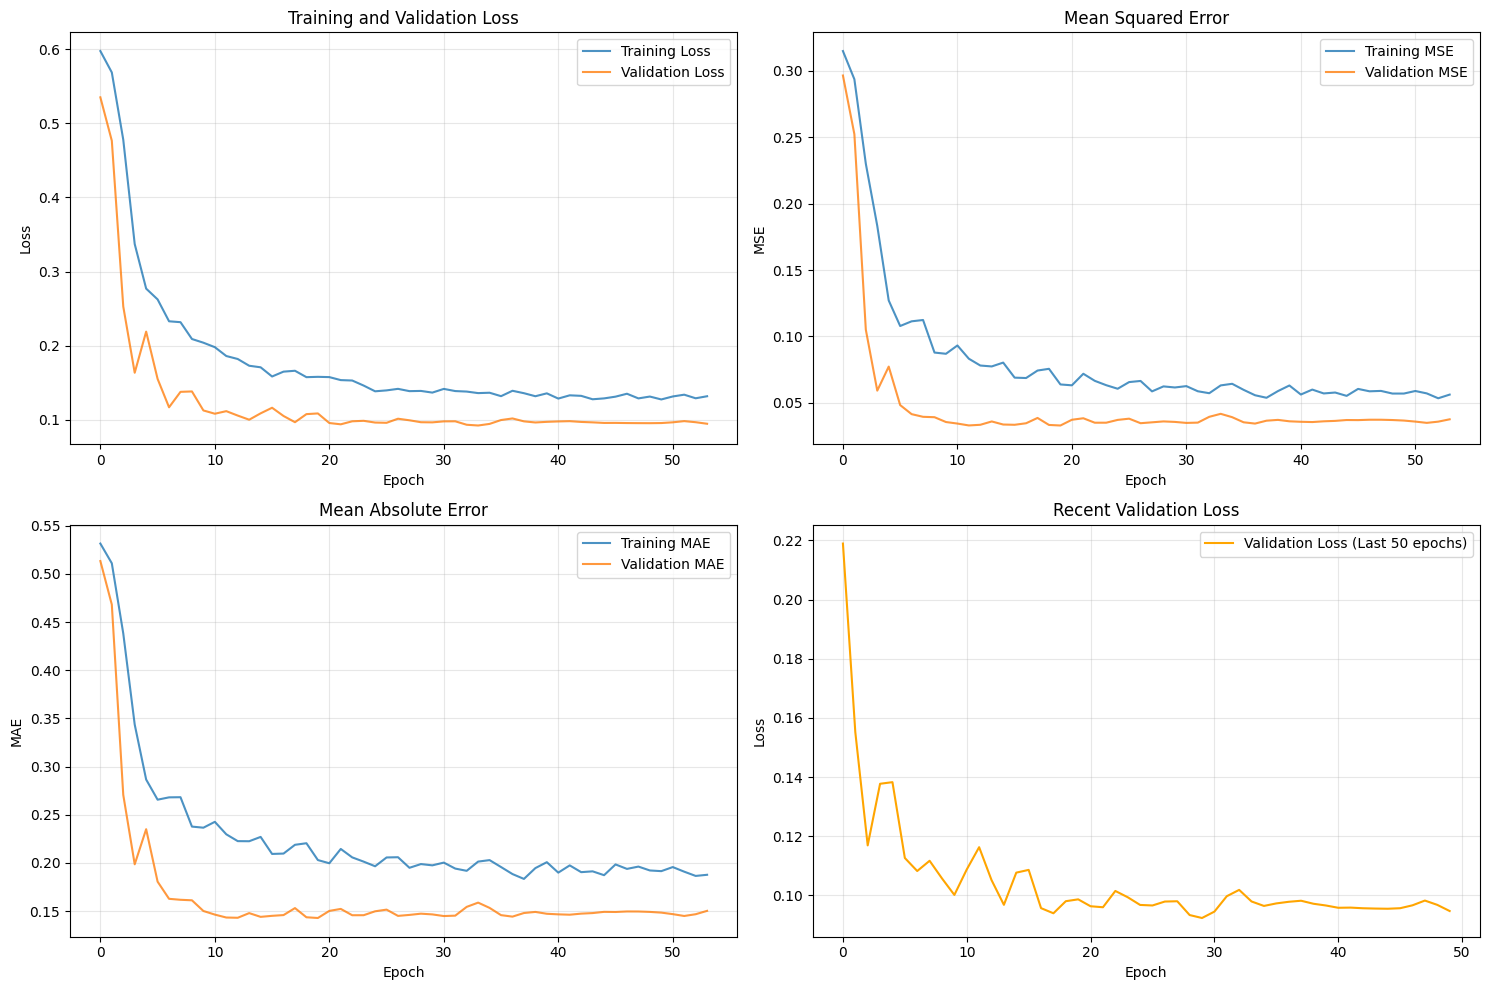

In [10]:
# Train model
trainer = LSTMTrainer(model)
trainer.compile_model(learning_rate=0.001)

history = trainer.train_model(
    X_train_scaled, y_train_scaled, 
    X_val_scaled, y_val_scaled,
    epochs=150, batch_size=64
)

# Plot training history
trainer.plot_training_history()

In [ ]:
# 3. Model Saving
print("\n" + "=" * 50)
print("MODEL SAVING")
print("=" * 50)

model_manager = ModelManager(model_path=MODEL_DIR)
model_manager.save_model(model, "lstm_model")


MODEL SAVING
Saving model to /Users/emmanuelaladejana/Workstation/fyp/k8s-lstm/notebook/models...
✓ HDF5 model saved to: /Users/emmanuelaladejana/Workstation/fyp/k8s-lstm/notebook/models/kubernetes_lstm_disaster_recovery.h5
✓ Model architecture saved to: /Users/emmanuelaladejana/Workstation/fyp/k8s-lstm/notebook/models/kubernetes_lstm_disaster_recovery_architecture.json
Model saving completed!


In [ ]:
# 4. Model Evaluation
print("\n" + "=" * 50)
print("MODEL EVALUATION")
print("=" * 50)

# Normalize test data
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = processor.scaler_features.transform(X_test_reshaped).reshape(X_test.shape)

# Make predictions on test set
test_predictions = model.predict(X_test_scaled, verbose=0)

# Denormalize predictions and targets
test_pred_reshaped = test_predictions.reshape(-1, test_predictions.shape[-1])
test_true_reshaped = y_test.reshape(-1, y_test.shape[-1])

test_pred_denorm = processor.scaler_targets.inverse_transform(test_pred_reshaped)
test_true_denorm = processor.scaler_targets.inverse_transform(test_true_reshaped)

# Calculate metrics
mse_cpu = mean_squared_error(test_true_denorm[:, 0], test_pred_denorm[:, 0])
mae_cpu = mean_absolute_error(test_true_denorm[:, 0], test_pred_denorm[:, 0])
rmse_cpu = np.sqrt(mse_cpu)

mse_memory = mean_squared_error(test_true_denorm[:, 1], test_pred_denorm[:, 1])
mae_memory = mean_absolute_error(test_true_denorm[:, 1], test_pred_denorm[:, 1])
rmse_memory = np.sqrt(mse_memory)

print("CPU Prediction Metrics:")
print(f"  - RMSE: {rmse_cpu:.4f}")
print(f"  - MAE: {mae_cpu:.4f}")
print(f"  - MSE: {mse_cpu:.4f}")

print("\nMemory Prediction Metrics:")
print(f"  - RMSE: {rmse_memory:.4f}")
print(f"  - MAE: {mae_memory:.4f}") 
print(f"  - MSE: {mse_memory:.4f}")



MODEL EVALUATION
CPU Prediction Metrics:
  - RMSE: 1013.7036
  - MAE: 1011.6910
  - MSE: 1027594.9394

Memory Prediction Metrics:
  - RMSE: 1111.1269
  - MAE: 1108.1942
  - MSE: 1234603.0706


In [13]:
# 5. Demonstrate Model Loading
print("\n" + "=" * 50)
print("MODEL LOADING DEMONSTRATION")
print("=" * 50)

# List saved models
model_manager.list_saved_models()

# Load model in different formats
print("\nTesting model loading...")

# Load SavedModel format
loaded_model_savedmodel = model_manager.load_model(
    "kubernetes_lstm_disaster_recovery", 
    load_format="h5"
)

# Test loaded model with a sample prediction
sample_input = X_test_scaled[:1]  # Take first test sample
original_prediction = model.predict(sample_input, verbose=0)
loaded_prediction = loaded_model_savedmodel.predict(sample_input, verbose=0)

print(f"Original model prediction shape: {original_prediction.shape}")
print(f"Loaded model prediction shape: {loaded_prediction.shape}")
print(f"Predictions match: {np.allclose(original_prediction, loaded_prediction)}")


MODEL LOADING DEMONSTRATION
Models in /Users/emmanuelaladejana/Workstation/fyp/k8s-lstm/notebook/models:
  - best_model.h5
  - kubernetes_lstm_disaster_recovery_architecture.json
  - kubernetes_lstm_disaster_recovery.h5
  - training_log.csv

Testing model loading...
Loading model from /Users/emmanuelaladejana/Workstation/fyp/k8s-lstm/notebook/models...
✓ HDF5 model loaded from: /Users/emmanuelaladejana/Workstation/fyp/k8s-lstm/notebook/models/kubernetes_lstm_disaster_recovery.h5
Original model prediction shape: (1, 12, 2)
Loaded model prediction shape: (1, 12, 2)
Predictions match: True


In [ ]:
def load_model(model_path):
    """
    Load model from different formats
    
    Args:
        model_name: Name of the model files
        load_format: h5'
    """   
    try:    
        model_path = os.path.join(model_path)
        model = keras.models.load_model(
            model_path,
            custom_objects={'loss_fn': disaster_aware_loss()}
        )
        print(f"✓ HDF5 model loaded from: {model_path}")
            
    except Exception:
        raise ValueError("Unable to load model")
    return model

In [ ]:
model_path = "./models/lstm_model.h5"

model = load_model(model_path)

✓ HDF5 model loaded from: models/kubernetes_lstm_disaster_recovery.h5


In [ ]:
# Test loaded model with a sample prediction
sample_input = X_test_scaled[:1]  # Take first test sample
original_prediction = model.predict(sample_input, verbose=0)
loaded_prediction = model.predict(sample_input, verbose=0)

print(f"Original model prediction shape: {original_prediction.shape}")
print(f"Loaded model prediction shape: {loaded_prediction.shape}")
print(f"Predictions match: {np.allclose(original_prediction, loaded_prediction)}")